In [1]:
import sys, os
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)

In [2]:
from PyHEADTAIL.skew_quad.skew_quad import SkewQuadrupole
from scipy.constants import c
import time
import numpy as np
from scipy.optimize import leastsq

%matplotlib inline
from matplotlib import pyplot as plt

plot = False
n_turns = 16384

PyHEADTAIL v1.5.0-51-gd4b16c3c71-dirty




In [3]:
def lorentzian(x,p):
    numerator =  (p[0]**2 )
    denominator = ( x - (p[1]) )**2 + p[0]**2
    y = p[2]*(numerator/denominator)
    return y

def residuals(p,y,x):
    err = y - lorentzian(x,p)
    return err

In [4]:
def get_spectra(bx, by):
    amp_x = np.fft.rfft(bx)
    freq_x = np.fft.rfftfreq(len(bx))
    amp_y = np.fft.rfft(by)
    freq_y = np.fft.rfftfreq(len(by))

    if plot == True:
        plt.plot(freq_x, np.abs(amp_x))
        plt.plot(freq_y, np.abs(amp_y))

        plt.grid('on')
        plt.yscale('log')
        plt.xlim(0.27, 0.33)
        
    #tune_x = freq_x[np.argmax(np.abs(amp_x))]
    #tune_y = freq_y[np.argmax(np.abs(amp_y))]
    #delta_Q = np.abs(tune_x - tune_y)
    #print delta_Q
    
    return np.abs(amp_x), np.abs(amp_y)

In [5]:
def run_machine(Qx, Qy, k_skew):
    n_macroparticles = 5e3

    intensity = 1e11
    Qp_x = 0.
    Qp_y = 0.

    # BEAM AND MACHNINE PARAMETERS
    # ============================
    from PyCERNmachines.CERNmachines import LHC
    longitudinal_focusing = 'linear'
    machine = LHC(n_segments=1, machine_configuration='450GeV',
                  longitudinal_focusing=longitudinal_focusing,
                  Qp_x=[Qp_x], Qp_y=[Qp_y],
                  Q_x=Qx, Q_y=Qy)

    # BEAM
    # ====
    epsn_x  = 3.75e-6
    epsn_y  = 3.75e-6
    sigma_z = 1.2e-9*c / 4.
    bunch = machine.generate_6D_Gaussian_bunch(
        n_macroparticles, intensity, epsn_x, epsn_y, sigma_z=sigma_z)

    skew_quad = SkewQuadrupole(k_skew)
    machine.one_turn_map.append(skew_quad)

    bx = np.zeros(n_turns)
    by = np.zeros(n_turns)

    print '\n--> Begin tracking...\n'
    for i in range(n_turns):
        t0 = time.clock()

        machine.track(bunch)
        bx[i] = bunch.mean_x()
        by[i] = bunch.mean_y()

        if i%1000 is not 0:
            continue

        print '{:4d} \t {:+3e} \t {:+3e} \t {:+3e} \t {:3e} \t {:3e} \t {:3f} \t {:3f} \t {:3f} \t {:3s}'.format(i, bunch.mean_x(), bunch.mean_y(), bunch.mean_z(), bunch.epsn_x(), bunch.epsn_y(), bunch.epsn_z(), bunch.sigma_z(), bunch.sigma_dp(), str(time.clock() - t0))

    print '\n*** Successfully completed!'

    fft_x, fft_y = get_spectra(bx, by)
    return fft_x[:], fft_y[:]

In [6]:
n_q = 21
k_skew = 5.e-4
qx_vec = np.linspace(64.3525, 64.3575, n_q)
qy_vec = qx_vec[::-1] - 5 #np.linspace(59.40, 59.20, n_q)

fft_vec_x = np.zeros((int(n_turns/2.+1), n_q))
fft_vec_y = np.zeros((int(n_turns/2.+1), n_q))

for i in np.arange(n_q):
    fft_vec_x[:,i], fft_vec_y[:,i] = run_machine(qx_vec[i], qy_vec[i], k_skew)

data_orig_x = fft_vec_x.copy()
data_orig_y = fft_vec_y.copy()

Synchrotron init. From kwargs: machine_configuration = '450GeV'
Synchrotron init. From kwargs: longitudinal_focusing = 'linear'
Synchrotron init. From kwargs: Q_y = 59.357500000000002
Synchrotron init. From kwargs: n_segments = 1
Synchrotron init. From kwargs: Q_x = 64.352500000000006
Synchrotron init. From kwargs: Qp_x = [0.0]
Synchrotron init. From kwargs: Qp_y = [0.0]

--> Begin tracking...

   0 	 +2.057557e-06 	 -9.093321e-06 	 +9.927092e-04 	 3.723164e-06 	 3.705638e-06 	 0.654565 	 0.092489 	 0.000375 	 0.001274
1000 	 -1.910692e-08 	 +2.683013e-07 	 -9.581589e-04 	 3.640956e-06 	 3.787991e-06 	 0.654565 	 0.090074 	 0.000385 	 0.000983
2000 	 -2.086380e-06 	 +8.987480e-06 	 -8.577971e-06 	 3.708612e-06 	 3.717234e-06 	 0.654565 	 0.090268 	 0.000385 	 0.000984
3000 	 +6.970055e-08 	 -3.572849e-06 	 +9.669694e-04 	 3.674357e-06 	 3.751897e-06 	 0.654565 	 0.092500 	 0.000375 	 0.000982
4000 	 +2.599988e-06 	 -7.547277e-06 	 -9.846026e-04 	 3.664276e-06 	 3.762949e-06 	 0.654565 

k_skew = 5.000e-04
Minimum tune separation C-=0.00545862573715
C-/k_skew = 10.917251


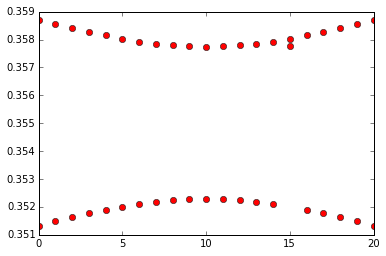

In [40]:
fft_vec_x = data_orig_x.copy()
fft_vec_y = data_orig_y.copy()

freq_pks = np.zeros((2, n_q))
n_peaks = 2
for idx_q in np.arange(n_q):    
    amp = fft_vec_x[:,idx_q] + fft_vec_y[:,idx_q]
    amp /= np.amax(amp)
    freq = np.fft.rfftfreq(n_turns)
    i_pk = 0
    n_points_fit = 5

    while i_pk < n_peaks:
        amp_max = np.amax(amp)
        idx_max = np.argmax(amp)
        freq_max = freq[idx_max]
    
        
        if amp_max < 0.02:
            print 'Amplitude below threshold'
            freq_pks[i_pk, idx_q] = freq_pks[i_pk-1, idx_q]
            break

        idx_low = idx_max - n_points_fit
        idx_high = idx_max + n_points_fit

        # initial values #
        p = [0.001, freq_max, amp_max]  # [hwhm, peak center, intensity] #

        # optimization # 
        pbest = leastsq(residuals, p, args=(amp[idx_low:idx_high], freq[idx_low:idx_high]), full_output=1)
        best_parameters = pbest[0]

        # fit to data #
        fit = lorentzian(freq, best_parameters)
        freq_pks[i_pk, idx_q] = best_parameters[1]
        amp -= fit
        i_pk += 1

plt.plot(freq_pks[0,:], 'or')
plt.plot(freq_pks[1,:], 'or')

delta_freqs = sorted(np.abs(freq_pks[0,:] - freq_pks[1,:]))
delta_freq = delta_freqs[1]

print 'k_skew = {:.3e}'.format(k_skew)
print 'Minimum tune separation C-={:s}'.format(str(np.min(delta_freq)))
print 'C-/k_skew = {:f}'.format(delta_freq/k_skew) 


(0.33, 0.37)

/home/lcarver/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


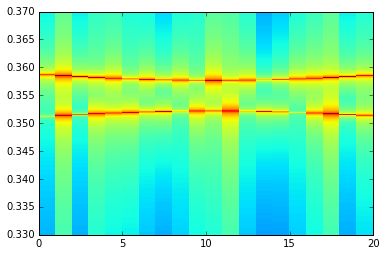

In [41]:
x=np.arange(0, n_q)
y = np.fft.rfftfreq(n_turns)
xx, yy = np.meshgrid(x, y)
zz = np.log(np.sum([fft_vec_x, fft_vec_y], axis=0))

plt.pcolormesh(xx, yy, zz)
plt.xlim(0, n_q-1)
plt.ylim(0.33, 0.37)

###Spectra x only